In [12]:
import numpy as np
import matplotlib.pyplot as plt

# PHYS 541 Final Project: The Cracker Barrel Peg Game
## Name: Jacob Buchanan

If you've ever been to a Cracker Barrel, you've probably made an attempt at the peg game. It's pretty straightforward. You have a triangle with some pegs and one open space to start. You have to jump over all the pegs and get as few as you can at the end. It's difficult to get a good solution (I always end up doing worse the more I try). I'd like to study this game a bit by writing a simulation of it.

This game is more officially titled "Peg Solitaire", and it dates back to 1697. Traditionally the boards are much larger, but the triangular version that Cracker Barrel has is easier to work with. See the Wikipedia article: https://en.wikipedia.org/wiki/Peg_solitaire

I'll define the board as a matrix (i x j) where j = i. I'll wrap up all the functionality into a few classes. You could run this without classes, but it'll be easier to use them to store information.

First I'll define a "space" class. It knows its own status: is there a peg in it, and which peg?

In [13]:
class Space:
    def __init__(self, peg=None):
        """
        Initialize a space object
        :param peg: Peg object, can be blank if no peg
        """
        self.peg = peg
    
    def set_peg(self, peg, reset=False):
        """
        Setter for peg. Throws RuntimeError if you try to put two pegs in one space.
        :param peg: Peg object 
        :param reset: Boolean to override peg checking
        :return: none
        """
        if self.has_peg() and not reset: raise RuntimeError
        self.peg = peg
        
    def remove_peg(self):
        """
        Removes and return the peg object
        :return: Peg object previously stored
        """
        peg = self.peg
        self.peg = None
        return peg

    def has_peg(self):
        """
        Does this space contain a peg?
        :return: 
        """
        if self.peg is not None:
            return True
        else:
            return False

I'll now define a peg. There are a lot of possibilities for this, but I'm not going to take them.

In [14]:
class Peg:
    """
    Peg object. Could be used to track each peg.
    """
    def __init__(self):
        pass

I'll define a move, which takes the initial and final point. It can print out what it does.

In [15]:
class Move:
    def __init__(self, p1, p2):
        """
        Initialize a move object
        :param p1: (x,y) tuple representing initial position
        :param p2: (x,y) tuple representing final position
        """
        self.p1 = p1
        self.p2 = p2
    
    def __str__(self):
        return f"Move peg at {self.p1} to {self.p2} which jumps over {self.jump_coord()}"
    
    def jump_coord(self):
        """
        gets the coordinate that the move jumps over
        :return: (x,y) of jumped position
        """
        diff_x = self.p2[0] - self.p1[0]
        if diff_x > 0:
            jumped_x = self.p2[0] - 1
        elif diff_x < 0:
            jumped_x = self.p2[0] + 1
        else:
            jumped_x = self.p2[0]
        diff_y = self.p2[1] - self.p1[1]
        if diff_y > 0:
            jumped_y = self.p2[1] - 1
        elif diff_y < 0:
            jumped_y = self.p2[1] + 1
        else:
            jumped_y = self.p2[1]
        return jumped_x, jumped_y

Now I'll define the board. This is effectively a matrix with 5 rows and n columns (where n is the row number).

In [16]:
class Board:
    def __init__(self, empty_point=(0,0)):
        """
        Initializes the board. Must provide an x and y position for the empty space
        :param empty_point: (x,y) tuple
        """
        self.board = [
            [Space()],
            [Space(), Space()],
            [Space(), Space(), Space()],
            [Space(), Space(), Space(), Space()],
            [Space(), Space(), Space(), Space(), Space()],
        ]
        self.setup_board(empty_point)
        self.current_moves = []
        self.move_history = []
        self.start = empty_point

    def setup_board(self, empty_pos=(0,0), reset=False):
        """
        Sets up the board by adding the pegs (except for the empty space).
        :param empty_pos: (x,y) tuple
        :param reset: Boolean, if resetting game
        :return: None
        """
        empty_space = False
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if not (i,j) == empty_pos:
                    self.board[i][j].set_peg(Peg(), reset=reset)
                else:
                    self.board[i][j] = Space()
                    empty_space = True
        if not empty_space:
            raise ValueError("One empty space required")
        
    def get_space(self, p):
        """
        Returns the Space object at some point (or none)
        :param p: (x,y) tuple
        :return: Space object if valid space, or None
        """
        if p in self:
            return self.board[p[0]][p[1]]
        else:
            return None
        
    def check_move(self, move):
        """
        Checks a move from p1 to p2 (assuming the jump spacing is valid)
        :param move: Move containing points
        :return: Boolean
        """
        if (move.p1 in self) and (move.p2 in self):
            if self.get_space(move.p1).has_peg():
                if not self.get_space(move.p2).has_peg():
                    if self.get_space(move.jump_coord()).has_peg():
                        return True
        return False
        
    def get_moves(self):
        """
        Gets the possible moves based on the current state of the board.
        :return: List of Move objects
        """
        moves = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j].has_peg():
                    # It has a peg, can it move?
                    for dx in (-2, 0, 2):
                        for dy in (-2, 0, 2):
                            move = Move((i,j),(i+dx,j+dy))
                            # Peg must move
                            if (dx, dy) == (0, 0):
                                continue
                            # No negative values
                            elif (i+dx < 0) or (j+dy < 0):
                                continue
                            elif dx*dy < 0:
                                continue
                            elif not self.check_move(move):
                                continue
                            else:
                                moves.append(move)
        self.current_moves = moves
        return moves
    
    def execute_move(self, move, record=True):
        """
        Changes the state of the board based on the provided Move. Can be recorded for future use
        :param move: Move object
        :param record: Boolean; True places the move in self.move_history
        :return: None
        """
        if self.check_move(move):
            # Remove peg at jump coord
            jump_coord = move.jump_coord()
            self.get_space(jump_coord).remove_peg()
            # Move peg
            peg = self.get_space(move.p1).remove_peg()
            self.get_space(move.p2).set_peg(peg)
            if record:
                self.move_history.append(move)
            
    def num_pegs(self):
        """
        Gets the number of pegs in the game at the current step
        :return: number of pegs (integer)
        """
        n = 0
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.get_space((i, j)).has_peg():
                    n += 1
        return n
    
    def print_game(self):
        """
        Resets the board and replays the game based on the move history. Prints board at each step.
        :return: None
        """
        self.setup_board(self.start, reset=True)
        print(self)
        for move in self.move_history:
            print(move)
            self.execute_move(move, record=False)
            print(self)
        
    def __str__(self):
        """
        Peg = 1, no peg = 0
        :return: None
        """
        output = ""
        for row in self.board:
            for space in row:
                if space.has_peg():
                    output += "1 "
                else:
                    output += "0 "
            output += "\n"
        return output
    
    def __contains__(self, item):
        """
        Check if coordinate is within the bounds of the board
        :param item: A tuple (x,y)
        :return: True or False
        """
        try:
            p = self.board[item[0]][item[1]]
            return True
        except IndexError:
            return False

Ok, now I'll try to run a simulation with this stuff. Here's a function to run the game with uniform probabilities for each possible move. 

In [17]:
def run_game(x0, y0):
    """
    Run the game with the initial space at p0 = (x0,y0)
    :param x0: x coordinate of empty space
    :param y0: y coordinate of empty space
    :return: (board object, number of moves)
    """
    n_moves = 0
    board = Board((x0,y0))
    moves = board.get_moves()
    while len(moves) != 0:
        prob = 1 / len(moves)
        prob_array = np.zeros(len(moves))
        prob_array += prob
        move_choice = np.random.choice(moves, p=prob_array)
        board.execute_move(move_choice)
        n_moves += 1
        moves = board.get_moves()
    return board, n_moves

Let's run this 1000 times and see what happens

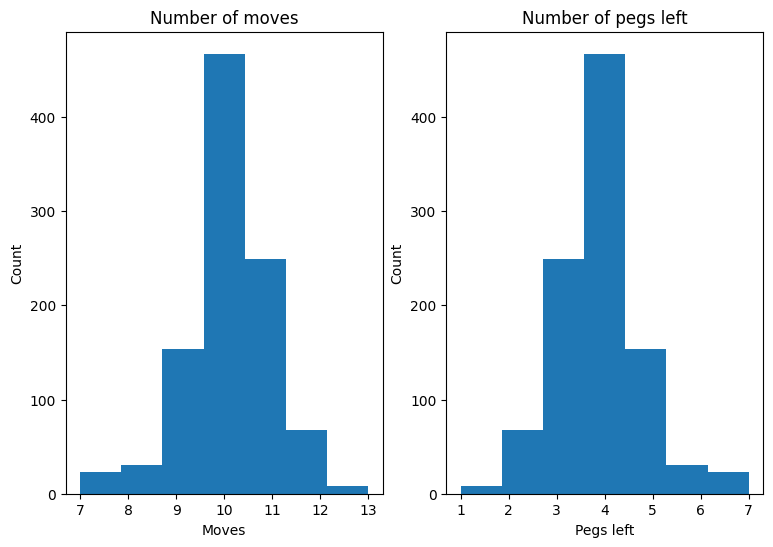

In [18]:
n_sims = 1000
moves = []
pegs = []
for i in range(n_sims):
    game = run_game(2,0)
    moves.append(game[1])
    pegs.append(game[0].num_pegs())

fig, ax = plt.subplots(1, 2, figsize=(9,6))
ax[0].hist(moves, bins=len(set(moves)))
ax[0].set_title("Number of moves")
ax[0].set_xlabel("Moves")
ax[0].set_ylabel("Count")
ax[1].hist(pegs, bins=len(set(pegs)))
ax[1].set_title("Number of pegs left")
ax[1].set_xlabel("Pegs left")
ax[1].set_ylabel("Count")

plt.show()

Cool, it works. It looks like it's quite unlikely to leave one peg 

In [19]:
def run_many_games(x0, y0, n_sims):
    """
    Runs the game at (x0,y0) starting space n_sims times.
    Returns the average number of pegs remaining per game.
    Also returns the board with one peg.
    :param x0: x coord of empty space
    :param y0: y coord of empty space
    :param n_sims: number of simulations to run
    :return: (Average number of pegs, list of Boards with 1 peg remaining)
    """
    moves = []
    pegs = []
    good_games = []
    for i in range(n_sims):
        game = run_game(x0,y0)
        moves.append(game[1])
        pegs.append(game[0].num_pegs())
        if game[0].num_pegs() == 1:
            good_games.append(game[0])
    return np.average(pegs), good_games

Now let's do that for each starting space. We'll see which space has the best odds of getting a good result.

In [20]:
pegs = {}
winning_games = []

for x in range(5):
    for y in range(5):
        if x >= y:
            # Valid space
            pegs[(x,y)], win = run_many_games(x,y,n_sims)
            winning_games.extend(win)

best = min(pegs, key=pegs.get)
print(Board((best[0], best[1])))

1 
1 1 
1 1 1 
1 1 1 1 
1 1 0 1 1 


This is supposedly the best starting board, which makes sense at it has the most initial moves. The board is symmetrical so you could rotate this.

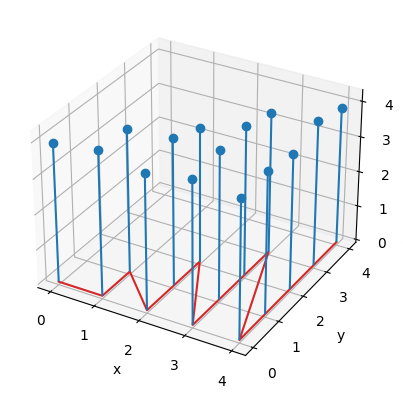

In [21]:
x = []
y= []
avgs = []

for p, avg in pegs.items():
    x.append(p[0])
    y.append(p[1])
    avgs.append(avg)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(x, y, avgs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Average number of pegs')  # Not working???

plt.show()

There's not much difference between the number of pegs left on average, which is a good thing for a game.

Now I'll print out a winning game based on the requested starting position.

In [22]:
start = (2,0)
if len(winning_games) > 0:
    for game in winning_games:
        if game.start == start:
            game.print_game()
            break

1 
1 1 
0 1 1 
1 1 1 1 
1 1 1 1 1 

Move peg at (4, 0) to (2, 0) which jumps over (3, 0)
1 
1 1 
1 1 1 
0 1 1 1 
0 1 1 1 1 

Move peg at (4, 2) to (4, 0) which jumps over (4, 1)
1 
1 1 
1 1 1 
0 1 1 1 
1 0 0 1 1 

Move peg at (2, 1) to (4, 1) which jumps over (3, 1)
1 
1 1 
1 0 1 
0 0 1 1 
1 1 0 1 1 

Move peg at (4, 0) to (4, 2) which jumps over (4, 1)
1 
1 1 
1 0 1 
0 0 1 1 
0 0 1 1 1 

Move peg at (3, 3) to (3, 1) which jumps over (3, 2)
1 
1 1 
1 0 1 
0 1 0 0 
0 0 1 1 1 

Move peg at (1, 1) to (3, 3) which jumps over (2, 2)
1 
1 0 
1 0 0 
0 1 0 1 
0 0 1 1 1 

Move peg at (4, 4) to (2, 2) which jumps over (3, 3)
1 
1 0 
1 0 1 
0 1 0 0 
0 0 1 1 0 

Move peg at (4, 3) to (4, 1) which jumps over (4, 2)
1 
1 0 
1 0 1 
0 1 0 0 
0 1 0 0 0 

Move peg at (1, 0) to (3, 0) which jumps over (2, 0)
1 
0 0 
0 0 1 
1 1 0 0 
0 1 0 0 0 

Move peg at (4, 1) to (2, 1) which jumps over (3, 1)
1 
0 0 
0 1 1 
1 0 0 0 
0 0 0 0 0 

Move peg at (2, 2) to (2, 0) which jumps over (2, 1)
1 
0 0 
1 0 0 
1 0 0 